In [2]:
import pandas as pd

In [3]:
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", 
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", 
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class","difficulty"
]


In [4]:
train = pd.read_csv('KDDTrain+.txt' , names = columns)
test = pd.read_csv('KDDTest+.txt' , names=columns)

In [5]:
train.drop(columns=['difficulty'] , inplace=True)
test.drop(columns=['difficulty'] , inplace=True)

In [6]:
attack_mapping = {
    'neptune': 'DOS', 'smurf': 'DOS', 'back': 'DOS', 'teardrop': 'DOS', 'pod': 'DOS', 'land': 'DOS',
    'apache2': 'DOS', 'processtable': 'DOS', 'udpstorm': 'DOS', 'mailbomb': 'DOS',
    
    'ipsweep': 'PROBE', 'portsweep': 'PROBE', 'nmap': 'PROBE', 'satan': 'PROBE', 'mscan': 'PROBE', 'saint': 'PROBE',
    
    'guess_passwd': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'imap': 'R2L',
    'ftp_write': 'R2L', 'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L',
    'httptunnel': 'R2L', 'named': 'R2L', 'sendmail': 'R2L',
    
    'buffer_overflow': 'U2R', 'rootkit': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R',
    'ps': 'U2R', 'xterm': 'U2R', 'xlock': 'U2R', 'xsnoop': 'U2R', 'worm': 'U2R',
    'sqlattack': 'U2R'
}


In [7]:
train['class'] = train['class'].replace(attack_mapping)
test['class'] = test['class'].replace(attack_mapping)


In [8]:
train['class'].value_counts()

class
normal    67343
DOS       45927
PROBE     11656
R2L         995
U2R          52
Name: count, dtype: int64

In [9]:
for col in train.select_dtypes(include=['number']).columns :
    train[col] = train[col].fillna(train[col].median())

In [10]:
for col in test.select_dtypes(include=['number']).columns :
    test[col] = test[col].fillna(test[col].median())

In [11]:
print(train['duration'].min() , train['duration'].max())
print(test['duration'].min() , test['duration'].max())

0 42908
0 57715


In [12]:
bins = [-0.1 , 0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000]
labels = ['0' , '0-10000','10000-20000','20000-30000','30000-40000','40000 - 50000' , '50000 - 60000']

In [13]:
train['duration_bin'] = pd.cut(train['duration'] , bins=bins , labels=labels)
test['duration_bin'] = pd.cut(test['duration'] , bins=bins , labels=labels)

In [14]:
train.drop(columns=['duration'] , inplace=True)
test.drop(columns=['duration'] , inplace=True)

In [15]:
x = train.drop(columns=['class'])
y = train['class']

In [16]:
from sklearn.model_selection import train_test_split


In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x , y, test_size=0.2 , random_state=42)

In [18]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder

le = LabelEncoder()

# List of categorical columns
categorical_cols = ['protocol_type', 'service', 'flag' , 'duration_bin']

# Apply label encoding to both train and test datasets
for col in categorical_cols:
    le.fit(x_train[col])  # Fit only on training data
    x_train[col] = le.transform(x_train[col])  # Transform training data
    x_test[col] = le.transform(x_test[col]) 

In [19]:
le2 = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [20]:
cat_train_df = x_train[categorical_cols]
cat_test_df = x_test[categorical_cols]

In [21]:
x_train = x_train.drop(columns=categorical_cols)
x_test = x_test.drop(columns=categorical_cols)



In [22]:
x_train_cols = x_train.columns
x_test_cols = x_test.columns

In [23]:
from sklearn.preprocessing import StandardScaler
# LEARNINGGGGGGGGGGGGGGGGG
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [24]:
x_train = pd.DataFrame(x_train , columns=x_train_cols)
x_test = pd.DataFrame(x_test , columns=x_test_cols)


In [25]:
print(x_train.shape)
print(cat_train_df.shape)


(100778, 37)
(100778, 4)


In [26]:
x_train = x_train.reset_index(drop=True)
cat_train_df = cat_train_df.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
cat_test_df = cat_test_df.reset_index(drop=True)


In [27]:
x_train = pd.concat([x_train, cat_train_df], axis=1)
x_test = pd.concat([x_test , cat_test_df], axis=1)

In [28]:
x_train

,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,duration_bin
0,-0.007494,-0.001979,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,1.236577,-0.011622,-0.037431,...,-0.414771,0.241937,-0.639420,-0.624562,-0.388181,-0.377012,1,24,9,0
1,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.479648,-0.288466,1.608758,1.619663,-0.388181,-0.377012,1,49,5,0
2,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.479648,-0.288466,-0.639420,-0.624562,2.871033,2.751507,1,24,1,0
3,-0.007487,-0.005244,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,1.236577,-0.011622,-0.037431,...,-0.479648,-0.288466,-0.639420,-0.624562,-0.388181,-0.377012,1,24,9,0
4,-0.007446,-0.005301,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,2.764213,-0.288466,-0.639420,-0.624562,-0.388181,-0.377012,2,44,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100773,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.479648,-0.288466,-0.639420,-0.624562,2.871033,2.751507,1,13,2,0
100774,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.447210,-0.288466,1.608758,1.619663,-0.388181,-0.377012,1,60,5,0
100775,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.479648,-0.288466,-0.639420,-0.624562,2.871033,2.751507,1,24,1,0
100776,-0.007479,-0.004350,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,1.236577,-0.011622,-0.037431,...,-0.317455,0.153537,-0.639420,-0.624562,-0.388181,-0.377012,1,24,9,0


In [29]:
x_train.columns

Index(['src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'protocol_type', 'service', 'flag',
       'duration_bin'],
      dtype='object')

In [30]:
x_test

,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,duration_bin
0,-0.007523,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,2.764213,-0.200066,-0.639420,-0.624562,-0.388181,-0.377012,2,12,9,0
1,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.447210,-0.288466,1.608758,1.619663,-0.388181,-0.377012,1,24,5,0
2,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.479648,-0.288466,1.608758,1.619663,-0.388181,-0.377012,1,47,5,0
3,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.479648,-0.288466,-0.639420,-0.624562,2.871033,2.751507,1,49,1,0
4,-0.007529,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,1.596423,-0.288466,-0.549493,-0.624562,1.665124,2.751507,1,49,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25190,-0.007497,-0.005092,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,1.236577,-0.011622,-0.037431,...,-0.479648,-0.288466,-0.639420,-0.624562,-0.388181,-0.377012,1,24,9,0
25191,-0.007527,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,2.764213,4.131561,-0.639420,-0.624562,-0.388181,-0.377012,0,14,9,0
25192,-0.005453,-0.005302,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,-0.808684,-0.011622,-0.037431,...,-0.285017,-0.288466,-0.639420,-0.624562,-0.322997,-0.377012,1,20,9,0
25193,-0.007399,-0.005229,-0.014089,-0.088966,-0.008649,-0.094907,-0.027434,1.236577,-0.011622,-0.037431,...,-0.479648,-0.288466,-0.594457,-0.579678,-0.388181,-0.377012,1,54,9,1


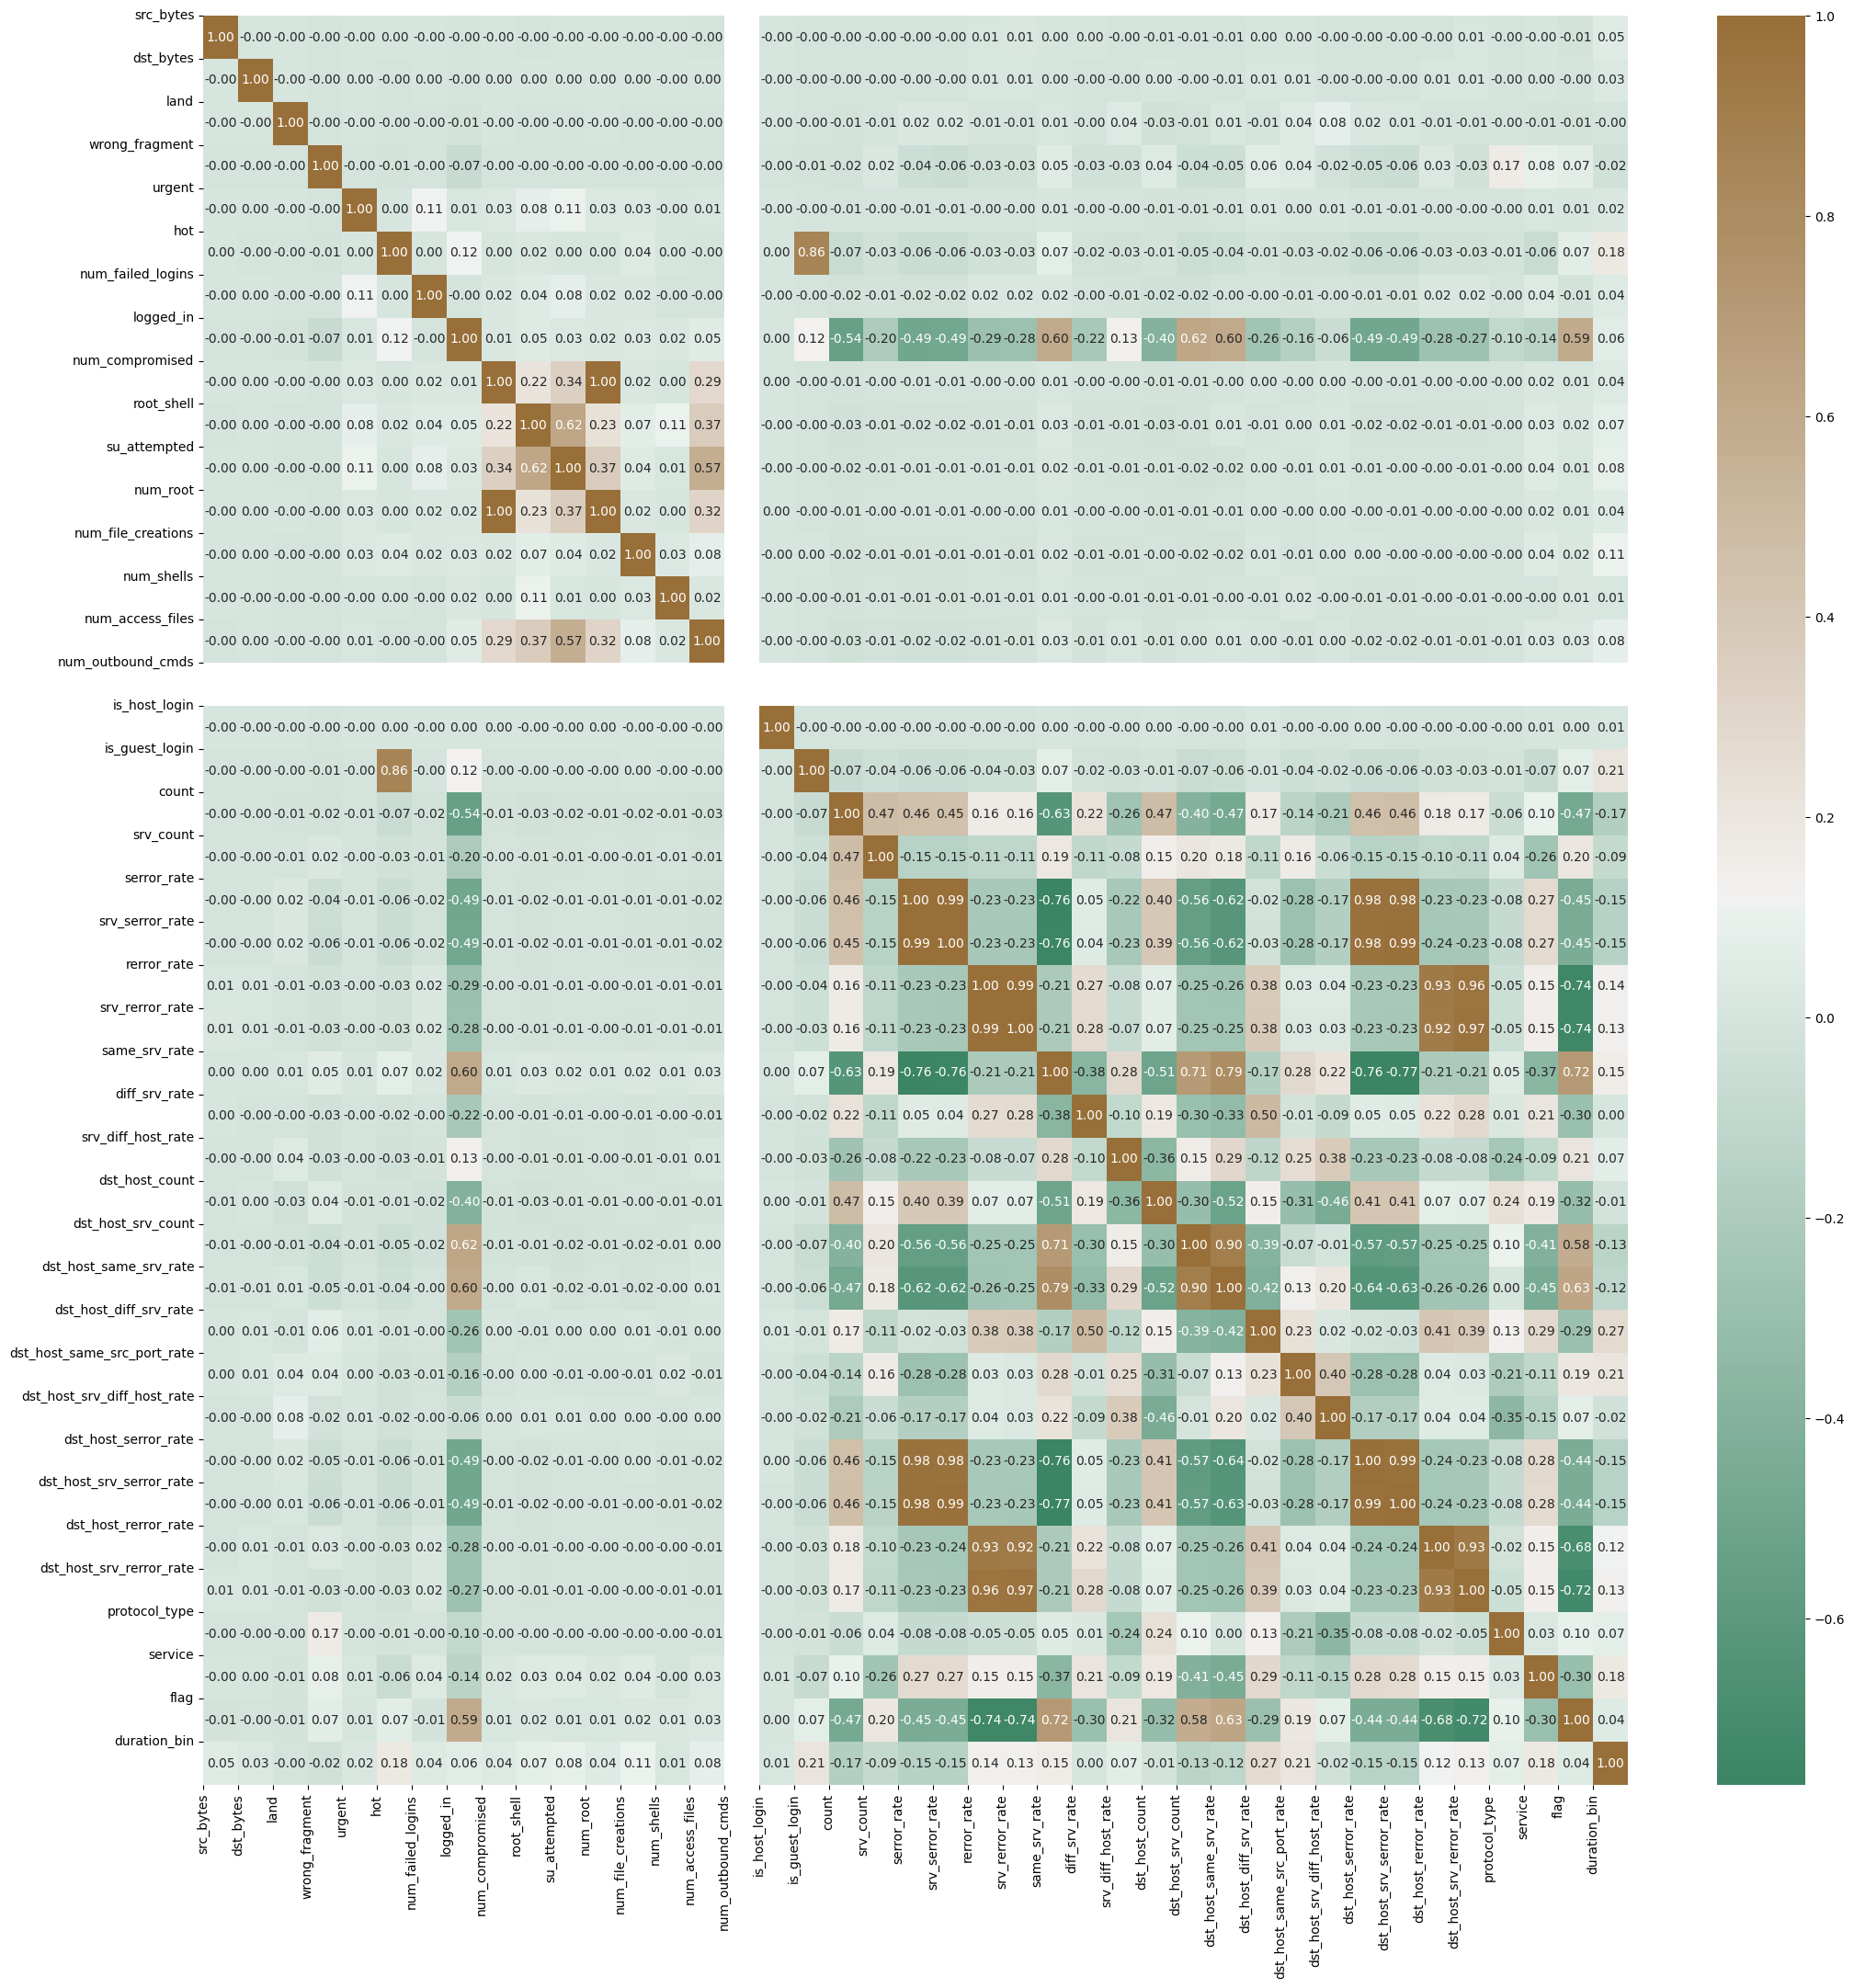

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = x_train.corr()
fig , ax = plt.subplots(figsize = (25,25))
colormap = sns.diverging_palette(150 , 50 , as_cmap = True)
sns.heatmap(corr , cmap = colormap , annot = True , fmt = ".2f")
plt.xticks(range(len(corr.columns)) , corr.columns)
plt.yticks(range(len(corr.columns)) , corr.columns)
plt.show()


CHECK ONE SIDE OF DIAGONAL, EITHER BELOW TRIANGLE OF DIAGONAL OR ELSE UPPER DIAGONAL

In [32]:
high_corr_cols = ['num_root' , 'srv_serror_rate' , 'srv_rerror_rate' , 'dst_host_serror_rate' , 'dst_host_srv_serror_rate']

In [33]:
# x_train = x_train.drop(columns=high_corr_cols)
# x_test = x_test.drop(columns=high_corr_cols)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100 , max_depth=30 , min_samples_split= 2  , min_samples_leaf=1 , max_features='log2' ,  random_state=42)
# {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [35]:
rf.fit(x_train , y_train)

RandomForestClassifier(max_depth=30, max_features='log2', random_state=42)

In [36]:
y_test_pred = rf.predict(x_test)

In [37]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9986


In [38]:
y_train_pred = rf.predict(x_train)

In [39]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train , y_train_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 1.0000


In [40]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation Accuracy: 0.9987 ± 0.0003


In [41]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [10 , 30 , 50, 100],   # Number of trees
#     'max_depth': [None, 10, 20, 30],  # Depth of each tree
#     'min_samples_split': [2, 5, 10],  # Min samples required to split a node
#     'min_samples_leaf': [1, 2, 4],    # Min samples required in a leaf node
#     'max_features': ['sqrt', 'log2']  # Number of features considered for splitting
# }

# # Initialize the Random Forest classifier
# rf = RandomForestClassifier(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf, 
#     param_grid=param_grid, 
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available CPU cores
#     verbose=2  # Print progress
# )

# # Fit the model
# grid_search.fit(x_train, y_train)

# # Best parameters
# print("Best parameters found: ", grid_search.best_params_)

# # Best model
# best_rf = grid_search.best_estimator_

# # Evaluate on test data
# test_accuracy = best_rf.score(x_test, y_test)
# print("Test Accuracy after tuning: ", test_accuracy)


In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
lr = LogisticRegression( random_state=42  , multi_class= 'multinomial' , max_iter=100)

In [44]:
lr.fit(x_train , y_train)

c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=42)

In [45]:
y_test_pred = lr.predict(x_test)

In [46]:
y_train_pred = lr.predict(x_train)

In [47]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lr, x_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in

Cross-validation Accuracy: 0.9545 ± 0.0010


c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train , y_train_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9535
Train Accuracy: 0.9538


c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Swaraj\OneDrive\Desktop\NSL-KDD\tf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in

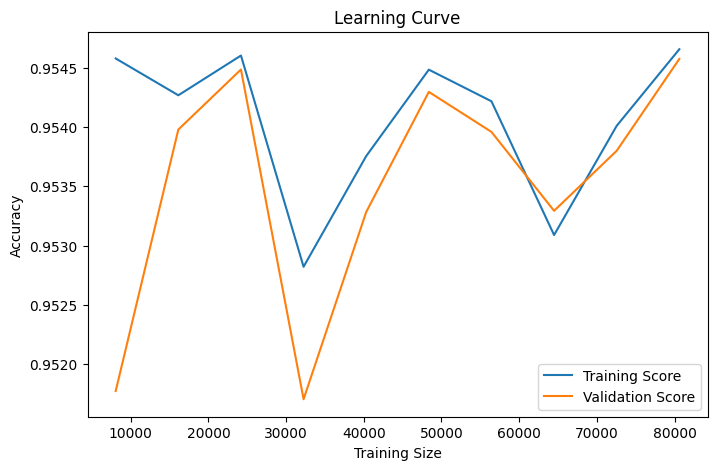

In [49]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    lr , x_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Score")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()
